## Telco

#### Pull Data Function (CSV or SQL with personal env file)

In [1]:
import os
import pandas as pd
from env import db_url

def get_telco_data():
    """
    get telco data will query the telco database and return all the relevant churn data within

    arguments: none

    return: a pandas dataframe
    """
    filename = "telco.csv"
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        query = """
        SELECT *
        FROM customers
        JOIN contract_types
        ON customers.contract_type_id = contract_types.contract_type_id
        JOIN internet_service_types
        ON customers.internet_service_type_id = internet_service_types.internet_service_type_id
        JOIN payment_types
        ON customers.payment_type_id = payment_types.payment_type_id;"""
        connection = db_url("telco_churn")
        df = pd.read_sql(query, connection)
        df.to_csv(filename, index=False)
    return df

#### Clean Function with Binary KWA (default=False)

In [2]:
from acquire import get_telco_data
import pandas as pd

def prep_telco(df_telco, binary=False):
    """
    This function prepares the telco dataset for classification exercises.

        It drops unnecessary columns,
        converts the 'total_charges' column to numeric,
        separates automatic payments from payment types,
        changes senior citizen to Yes/No,
        calculates tenure in months and years,
        changes True/False values to Yes/No,
        creates a new column 'total_add_ons' that counts all of the add ons.
    """
    # Drop the joiner columns from SQL and definitely useless columns
    df_telco = df_telco.drop(
        columns=[
            "customer_id",
            "internet_service_type_id",
            "contract_type_id",
            "payment_type_id",
            "contract_type_id.1",
            "internet_service_type_id.1",
            "payment_type_id.1",
        ]
    )
    # Fill NA in internet service type with what the rest of the table uses, 'No internet service'.
    df_telco["internet_service_type"].fillna("No internet service", inplace=True)
    
    # As we've noticed before, ['total_charges'] is detected as an object, but holds mainly numbers. We'll use pd.to_numeric() to force everything to a number,
    # and anything that it cannot convert, we'll make it Null and investigate those.
    df_telco["total_charges"] = pd.to_numeric(
        df_telco["total_charges"], errors="coerce"
    )
    # Total charges = 0 also has Tenure = 0. We'll assume they're new and haven't been charged
    df_telco["total_charges"].fillna(0, inplace=True)

    # Automatic payments could be important for churn, so we will separate it from the payment method
    df_telco["automatic_payments"] = (
        df_telco["payment_type"] == "Bank transfer (automatic)"
    ) | (df_telco["payment_type"] == "Credit card (automatic)")

    # Now that it is separated, we remove 'automatic_payment' from the payment types. Made casing uniform
    df_telco["payment_type"].replace(
        {
            "Electronic check": "electronic check",
            "Mailed check": "mailed check",
            "Credit card (automatic)": "credit card",
            "Bank transfer (automatic)": "bank transfer",
        },
        inplace=True,
    )

    # Change senior_citizen to Yes/No for better visuals
    df_telco["senior_citizen"].replace({0: "No", 1: "Yes"}, inplace=True)

    # Bin the tenure into groups of 12 to separate by year
    df_telco["tenure (years)"] = df_telco["tenure"].apply(
        lambda x: int((x - 1) / 12) + 1
    )
    
    # Change from True / False to Yes / No for visuals and uniformity, also for tablewide binary conversion later
    df_telco["automatic_payments"].replace({False: "No", True: "Yes"}, inplace=True)

    # Create a total add ons that counts all of the add ons
    df_telco["total_add_ons"] = df_telco[
        [
            "phone_service",
            "online_security",
            "online_backup",
            "device_protection",
            "tech_support",
            "streaming_tv",
            "streaming_movies",
        ]
    ].apply(lambda x: (x == "Yes").sum(), axis=1)
    
    # Rename some columns 
    df_telco.rename(columns={'tenure': 'tenure (months)',
                             'partner': 'married',
                             'dependents': 'kids',
                             }, inplace=True)

    if binary == False:
        return df_telco
    else:
        df_telco = telco_binary(df_telco)
        return df_telco


    
def telco_binary(df_telco):
    df_telco.replace({
            'No internet service': 0,
            'No phone service': 0,
            'No': 0,
            'Yes': 1,
            'Male': 1, 
            'Female': 0}, inplace=True)
        
    # 3 Categories (but we want to keep all 3)
    categorical = ['contract_type', 'payment_type', 'internet_service_type']

    cat = pd.get_dummies(df_telco[categorical], drop_first=False, dtype='int')

    # Drop redundant columns
    cat.drop(columns='internet_service_type_0', inplace=True)

    # Rename for uniformity
    cat.rename(columns={'contract_type_Month-to-month':'month_to_month_contract',
                        'contract_type_One year':'one_year_contract',
                        'contract_type_Two year':'two_year_contact',
                        'payment_type_bank transfer':'bank_transfer_payment',
                        'payment_type_credit card':'credit_card_payment', 
                        'payment_type_electronic check':'e_check_payment',
                        'payment_type_mailed check':'mailed_check_payment',
                        'internet_service_type_DSL':'dsl_internet',
                        'internet_service_type_Fiber optic':'fiber_optic_internet'}
            , inplace=True)

    df_telco = pd.concat([df_telco, cat], axis=1)
    return df_telco

#### Good Information Function for Dataframe

In [3]:
import pandas as pd

def check_columns(df):
    """
    This function takes in a pandas DataFrame and prints out the name of each column,
    the number of unique values in each column, and the unique values themselves.

    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame to be checked.
    """
    for column in df.columns:
        print(f"{column} ({df[column].nunique()})")
        print(f"Unique Values: {df[column].unique()}")
        print(f"Null Values: {df[column].isna().sum()}")
        print("")

### Prepping Telco

In [4]:
# Get the data (CSV or pull from SQL with personal env file)

df_telco_full = get_telco_data()

In [5]:
# Clean the dataframe, optionally use binary=True to output the binary version. (Default is False)

# Use non-binary for better visualization
df_telco = prep_telco(df_telco_full)

In [6]:
check_columns(df_telco)

gender (2)
Unique Values: ['Female' 'Male']
Null Values: 0

senior_citizen (2)
Unique Values: ['No' 'Yes']
Null Values: 0

married (2)
Unique Values: ['Yes' 'No']
Null Values: 0

kids (2)
Unique Values: ['Yes' 'No']
Null Values: 0

tenure (months) (73)
Unique Values: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42
  0]
Null Values: 0

phone_service (2)
Unique Values: ['Yes' 'No']
Null Values: 0

multiple_lines (3)
Unique Values: ['No' 'Yes' 'No phone service']
Null Values: 0

online_security (3)
Unique Values: ['No' 'Yes' 'No internet service']
Null Values: 0

online_backup (3)
Unique Values: ['Yes' 'No' 'No internet service']
Null Values: 0

device_protection (3)
Unique Values: ['No' 'Yes' 'No internet service']
Null Values: 0

tech_support (3)
Unique Values: ['Yes' 'No' 'No internet service']
Null Values: 0

streami

### Viz

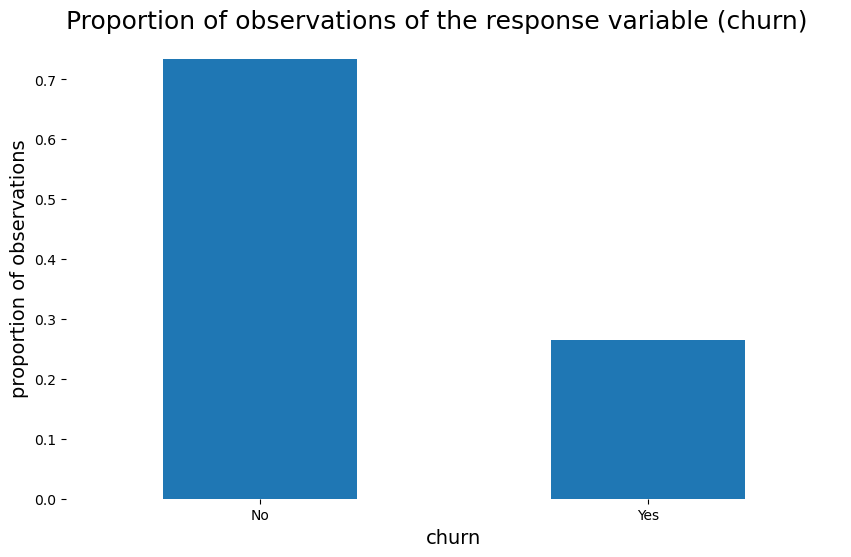

In [22]:
import matplotlib.pyplot as plt

# create a figure
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(111)

# proportion of observation of each class
prop_response = df_telco['churn'].value_counts(normalize=True)

# create a bar plot showing the percentage of churn
prop_response.plot(kind='bar', 
                   ax=ax)
                   # color=['springgreen','salmon'])

# set title and labels
ax.set_title('Proportion of observations of the response variable (churn)',
             fontsize=18, loc='left')
ax.set_xlabel('churn',
              fontsize=14)
ax.set_ylabel('proportion of observations',
              fontsize=14)
ax.tick_params(rotation='auto')

# eliminate the frame from the plot
spine_names = ('top', 'right', 'bottom', 'left')
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)

- This is an imbalanced data set.

- Both classes are not equally distributed among all observations, being 'No' the majority class (73.42%).

- When modeling, this imbalance will most likely lead to a large number of false negatives.

In [24]:
import math

def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df_telco[column], df_telco['churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0) # color=['springgreen','salmon'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proportion of observations by ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

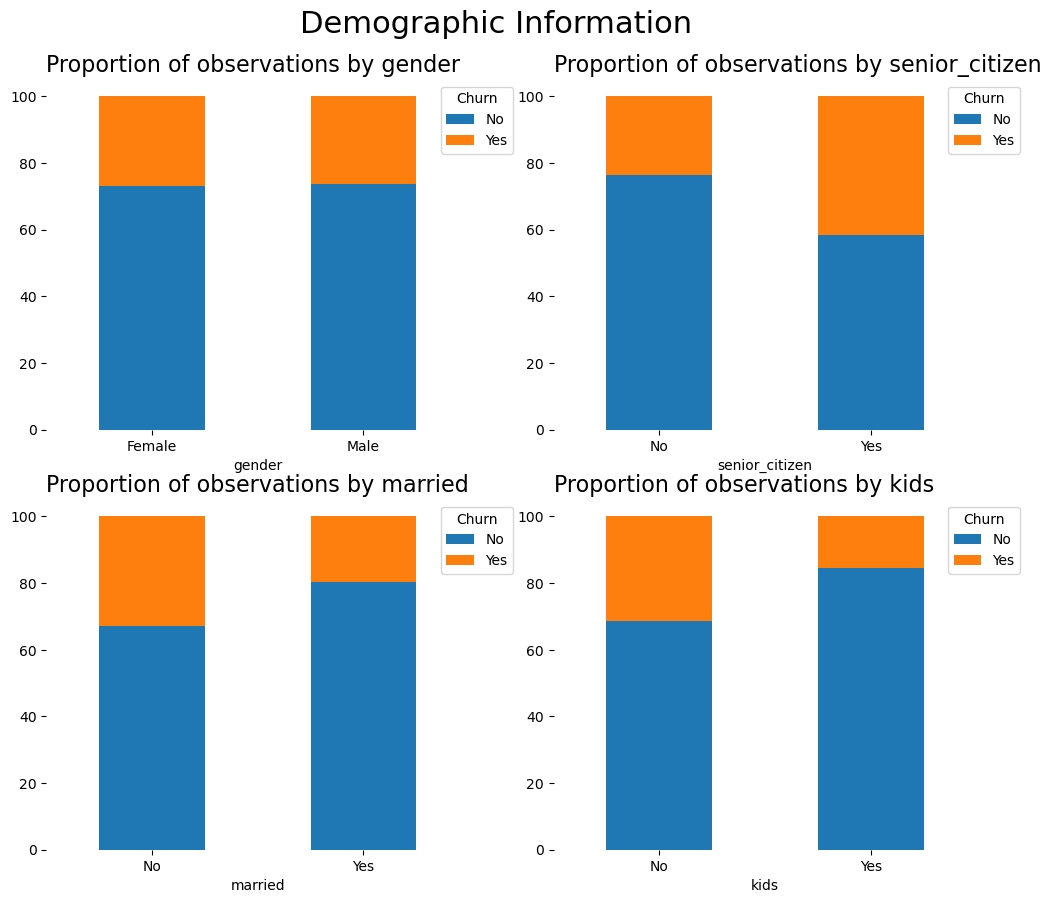

In [25]:
# demographic column names
demographic_columns = ['gender', 'senior_citizen', 'married', 'kids']

# stacked plot of demographic columns
percentage_stacked_plot(demographic_columns, 'Demographic Information')

- The churn rate of senior citizens is almost double that of young citizens.

- We do not expect gender to have significant predictive power. A similar percentage of churn is shown both when a customer is a man or a woman.

- Customers with a partner churn less than customers with no partner.

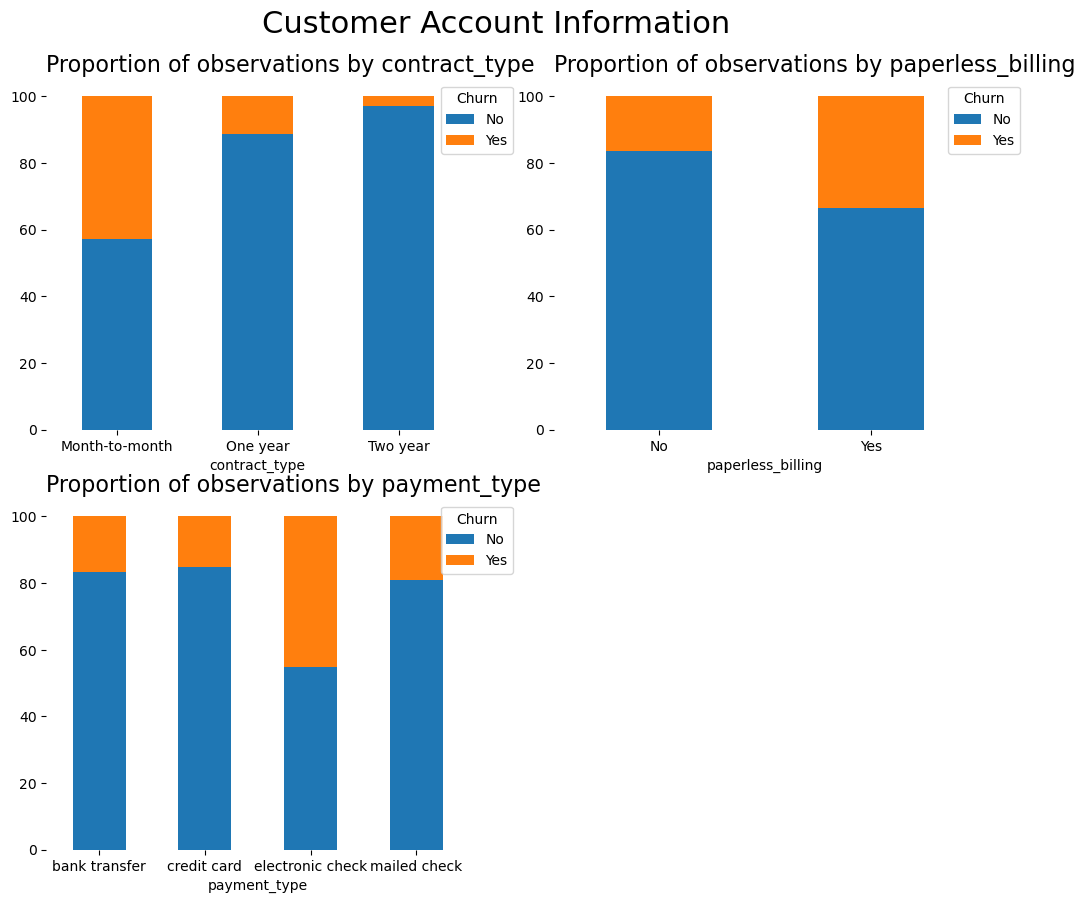

In [26]:
# Account Information
account_columns = ['contract_type', 'paperless_billing', 'payment_type']

# stacked plot of customer account columns
percentage_stacked_plot(account_columns, 'Customer Account Information')

- Customers with month-to-month contracts have higher churn rates compared to clients with yearly contracts.

- Customers who opted for an electronic check as paying method are more likely to leave the company.

- Customers subscribed to paperless billing churn more than those who are not subscribed.

In [27]:
def histogram_plots(columns_to_plot, super_title):
    # set number of rows and number of columns
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)


    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # histograms for each class (normalized histogram)
        df_telco[df_telco['churn']=='No'][column].plot(kind='hist', ax=ax, density=True, 
                                                       alpha=0.5, label='No') # color='springgreen'
        df_telco[df_telco['churn']=='Yes'][column].plot(kind='hist', ax=ax, density=True,
                                                        alpha=0.5, label='Yes') # color='salmon'
        
        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='churn', fancybox=True)

        # set title and labels
        ax.set_title('Distribution of ' + column + ' by churn',
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

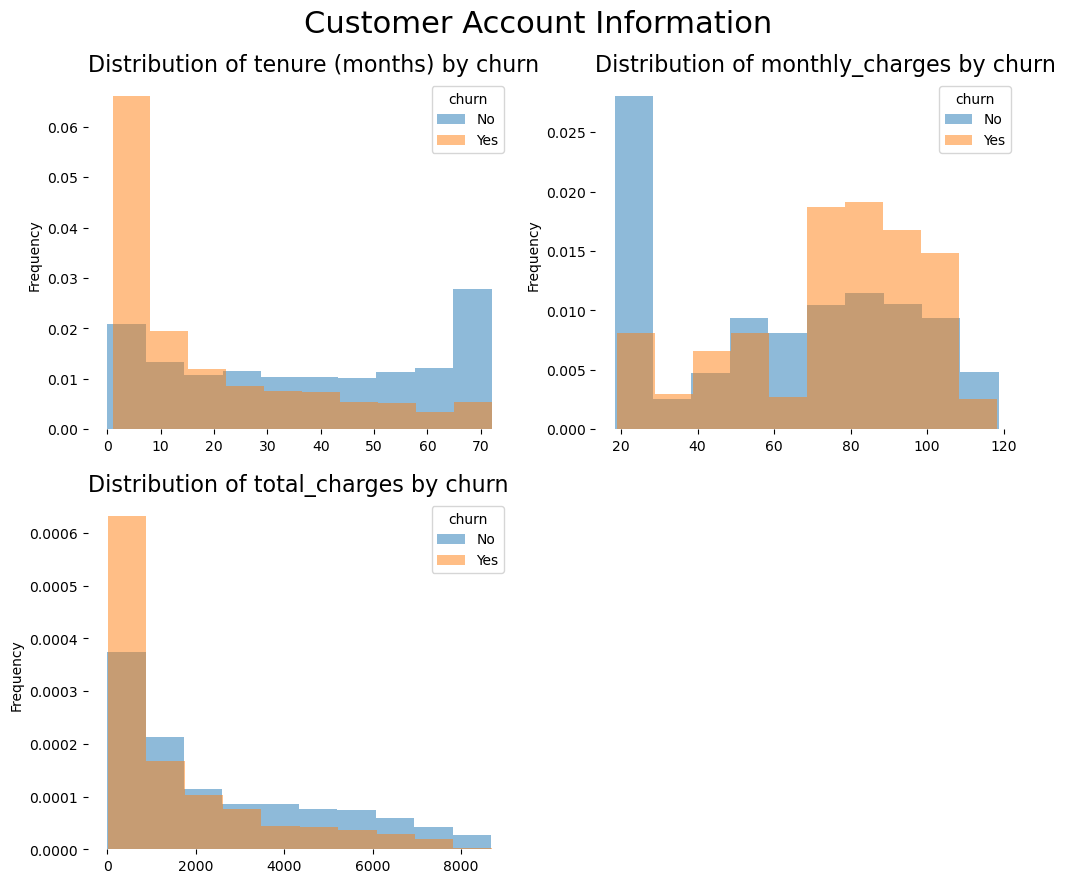

In [28]:
# customer account column names
account_columns_numeric = ['tenure (months)', 'monthly_charges', 'total_charges']

# histogram of costumer account columns 
histogram_plots(account_columns_numeric, 'Customer Account Information')

- The churn rate tends to be larger when monthly charges are high.

- New customers (low tenure) are more likely to churn.

- Clients with high total charges are less likely to leave the company.

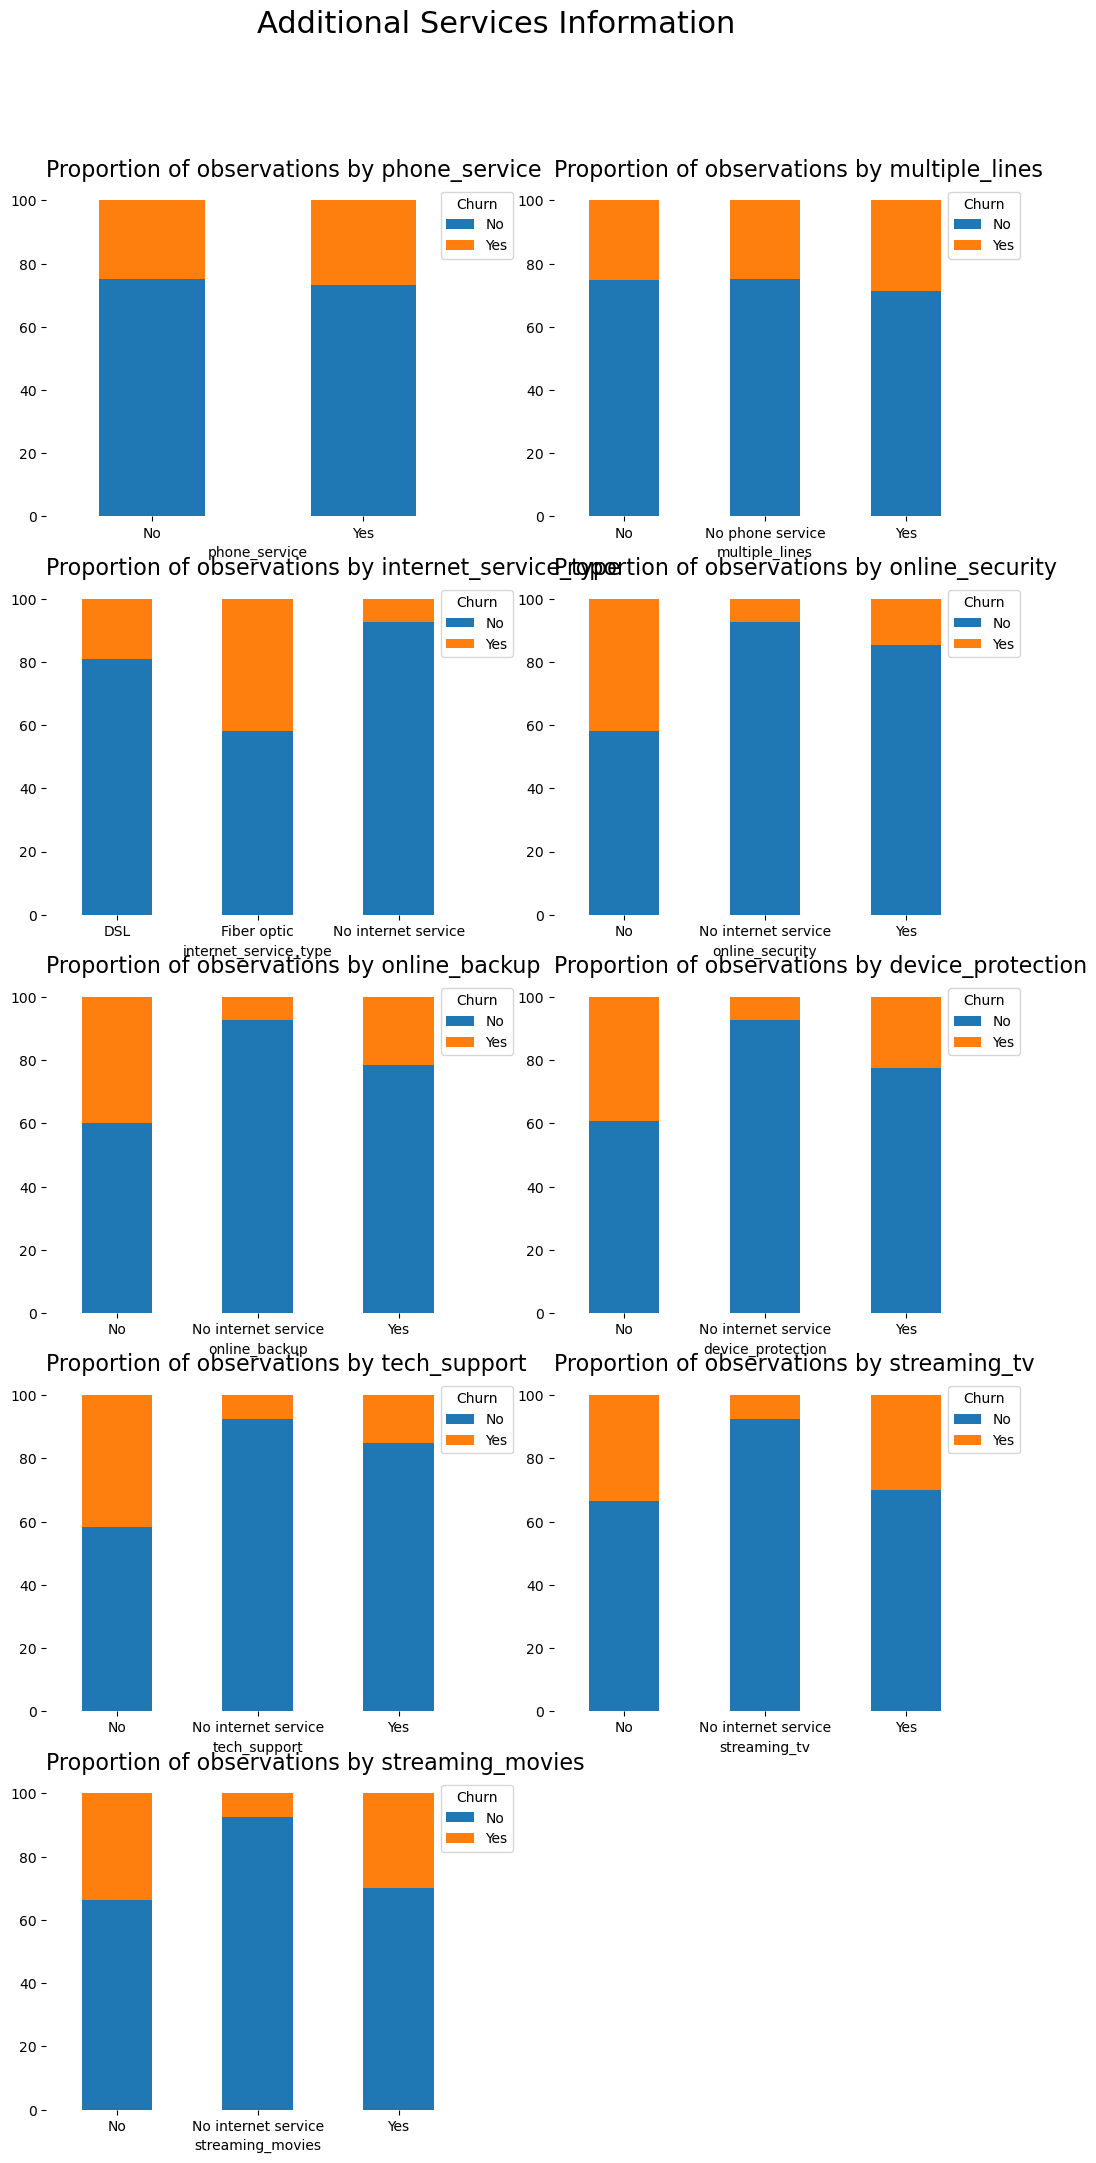

In [29]:
# services column names
services_columns = ['phone_service', 'multiple_lines', 'internet_service_type', 'online_security',
                   'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Additional Services Information')

- We do not expect phone attributes (PhoneService and MultipleLines) to have significant predictive power. The percentage of churn for all classes in both independent variables is nearly the same.

- Clients with online security churn less than those without it.

- Customers with no tech support tend to churn more often than those with tech support.

`sklearn`'s `mutual_info_score` is a function that computes the mutual information between two random variables. Mutual information is a measure of the amount of information that one random variable contains about another random variable. It is defined as the reduction in uncertainty about one variable given knowledge of the other variable.

In the context of machine learning, mutual information is often used as a feature selection method. It can be used to measure the dependence between a feature and the target variable, and can help identify features that are most relevant for predicting the target variable.

The `mutual_info_score` function takes two arrays as input, representing the two random variables, and returns the mutual information between them. The function can be used with both discrete and continuous variables, and can handle multiclass classification problems.

Note that mutual information is a symmetric measure, meaning that the mutual information between variable A and variable B is the same as the mutual information between variable B and variable A.

In [16]:
#The Scikit-Learn library has implemented mutual information in the metrics package.
# The following code computes the mutual information score between each categorical 
# variable of the data set and the Churn variable.

from sklearn.metrics import mutual_info_score

def compute_mutual_information(categorical_series):
    return mutual_info_score(categorical_series, df_telco['churn'])

# select categorial variables excluding the response variable 
categorical_variables = df_telco.select_dtypes(include=object).drop('churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
print(feature_importance)

contract_type            0.098453
online_security          0.064677
tech_support             0.063021
internet_service_type    0.055574
online_backup            0.046792
payment_type             0.044519
device_protection        0.043917
streaming_movies         0.032001
streaming_tv             0.031908
automatic_payments       0.022886
paperless_billing        0.019194
kids                     0.014467
married                  0.011454
senior_citizen           0.010577
multiple_lines           0.000801
phone_service            0.000072
gender                   0.000037
dtype: float64


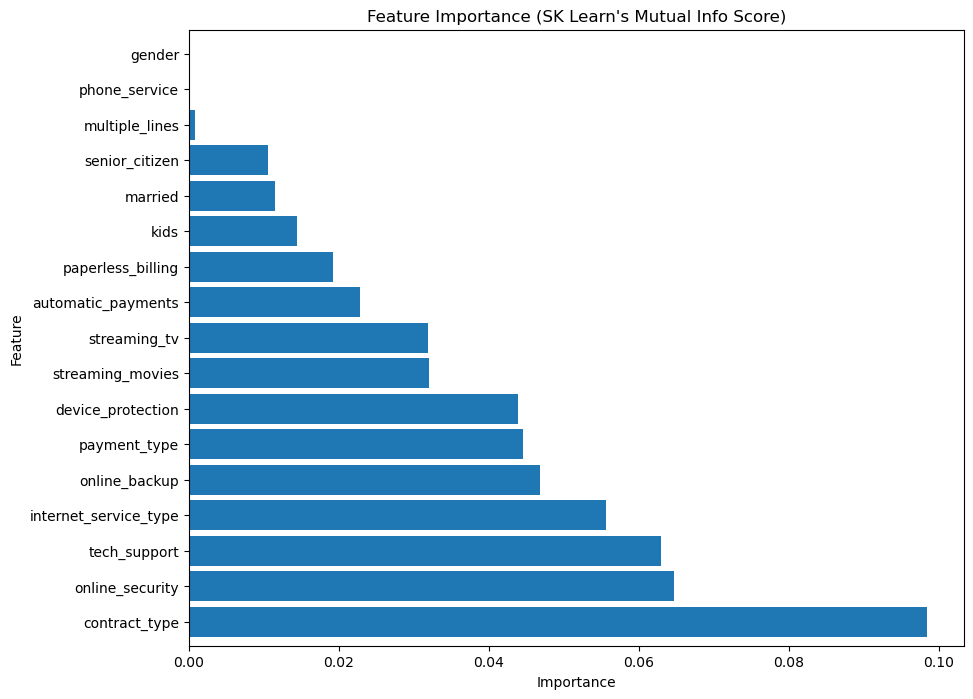

In [31]:
import matplotlib.pyplot as plt

feature_importance.sort_values(ascending=False)
ax = feature_importance.plot(kind='barh', figsize=(10,8), zorder=2, width=0.85) # color='#86bf91'
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title("Feature Importance (SK Learn's Mutual Info Score)")
plt.show()

- Gender, phone_service, and multiple_lines have a mutual information score really close to 0, meaning those variables do not have a strong relationship with the target. 

- This information is in line with the conclusions we have previously drawn by visualizing the data. In the following steps, we should consider removing those variables from the data set before training as they do not provide useful information for predicting the outcome.

### Make Binary

In [33]:
def telco_binary(df_telco):
    df_telco.replace({
            'No internet service': 0,
            'No phone service': 0,
            'No': 0,
            'Yes': 1,
            'Male': 1, 
            'Female': 0}, inplace=True)
        
    # 3 Categories (but we want to keep all 3)
    categorical = ['contract_type', 'payment_type', 'internet_service_type']

    cat = pd.get_dummies(df_telco[categorical], drop_first=False, dtype='int')

    # Drop redundant columns
    cat.drop(columns='internet_service_type_0', inplace=True)

    # Rename for uniformity
    cat.rename(columns={'contract_type_Month-to-month':'month_to_month_contract',
                        'contract_type_One year':'one_year_contract',
                        'contract_type_Two year':'two_year_contact',
                        'payment_type_bank transfer':'bank_transfer_payment',
                        'payment_type_credit card':'credit_card_payment', 
                        'payment_type_electronic check':'e_check_payment',
                        'payment_type_mailed check':'mailed_check_payment',
                        'internet_service_type_DSL':'dsl_internet',
                        'internet_service_type_Fiber optic':'fiber_optic_internet'}
            , inplace=True)

    df_telco = pd.concat([df_telco, cat], axis=1)
    return df_telco

In [ ]:
df_telco = telco_binary(df_telco)

### Split

In [32]:
def split_data(df, target):
    """
    take in a DataFrame and return train, validate, and test DataFrames; stratify on a specified variable.
    return train, validate, test DataFrames.
    """
    train_validate, test = train_test_split(
        df, test_size=0.2, random_state=123, stratify=df[target]
    )
    train, validate = train_test_split(
        train_validate, test_size=0.3, random_state=123, stratify=train_validate[target]
    )
    print(f"train: {len(train)} ({round(len(train)/len(df), 2)*100}% of {len(df)})")
    print(
        f"validate: {len(validate)} ({round(len(validate)/len(df), 2)*100}% of {len(df)})"
    )
    print(f"test: {len(test)} ({round(len(test)/len(df), 2)*100}% of {len(df)})")

    return train, validate, test

In [ ]:
split_data()